In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql.functions import col, mean, count
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.clustering import BisectingKMeans, KMeans
from pyspark.ml.functions import vector_to_array
from pyspark.ml.classification import (
    LogisticRegression,
    DecisionTreeClassifier,
    RandomForestClassifier,
    NaiveBayes,
)
from pyspark.ml.feature import (
    VectorAssembler,
    MinMaxScaler,
    StringIndexer,
    PCA
)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Создание Spark сессии
spark = SparkSession.builder.appName("Crop_Recommendation").getOrCreate() # type: ignore
data = spark.read.csv("Crop_Recommendation.csv", header="True")
dataPD = pd.read_csv("Crop_Recommendation.csv")

# Переименование столбцов
data = (
    data.withColumnRenamed("Nitrogen", "Азот")
    .withColumnRenamed("Phosphorus", "Фосфор")
    .withColumnRenamed("Potassium", "Калий")
    .withColumnRenamed("Temperature", "Температура")
    .withColumnRenamed("Humidity", "Влажность")
    .withColumnRenamed("pH_Value", "Значение pH")
    .withColumnRenamed("Rainfall", "Осадки")
    .withColumnRenamed("Crop", "Kультура")
)

data.printSchema()
data.show(5)

# Вывод минимальных и максимальных значений каждого числового столбца
data.describe().select(
    "summary", *[f.round(c, 2).alias(c) for c in data.columns[:-1]]
).show()

# Количество записей по каждой культуре
crop_counts = data.groupBy('Kультура').agg(count('Kультура').alias('count'))
crop_counts.show()
"""
# Перевод в пандас
pandas_df = crop_counts.toPandas()

# График
plt.figure(figsize=(14, 8))
sns.barplot(x='Kультура', y='count', data=pandas_df, palette='viridis')
plt.title('Number of Records per Crop')
plt.xlabel('Crop')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()
"""

"""
# Вывод уникальных значений типов культур
culture_types = data.select("Kультура").distinct().rdd.flatMap(lambda x: x).collect()
print("Уникальные культуры:")
print(culture_types)
"""

root
 |-- Азот: string (nullable = true)
 |-- Фосфор: string (nullable = true)
 |-- Калий: string (nullable = true)
 |-- Температура: string (nullable = true)
 |-- Влажность: string (nullable = true)
 |-- Значение pH: string (nullable = true)
 |-- Осадки: string (nullable = true)
 |-- Kультура: string (nullable = true)

+----+------+-----+-----------+-----------+-----------+-----------+--------+
|Азот|Фосфор|Калий|Температура|  Влажность|Значение pH|     Осадки|Kультура|
+----+------+-----+-----------+-----------+-----------+-----------+--------+
|  90|    42|   43|20.87974371|82.00274423|6.502985292|202.9355362|    Rice|
|  85|    58|   41|21.77046169|80.31964408|7.038096361|226.6555374|    Rice|
|  60|    55|   44|23.00445915| 82.3207629|7.840207144|263.9642476|    Rice|
|  74|    35|   40|26.49109635|80.15836264|6.980400905|242.8640342|    Rice|
|  78|    42|   42|20.13017482|81.60487287|7.628472891|262.7173405|    Rice|
+----+------+-----+-----------+-----------+-----------+-------

'\n# Вывод уникальных значений типов культур\nculture_types = data.select("Kультура").distinct().rdd.flatMap(lambda x: x).collect()\nprint("Уникальные культуры:")\nprint(culture_types)\n'

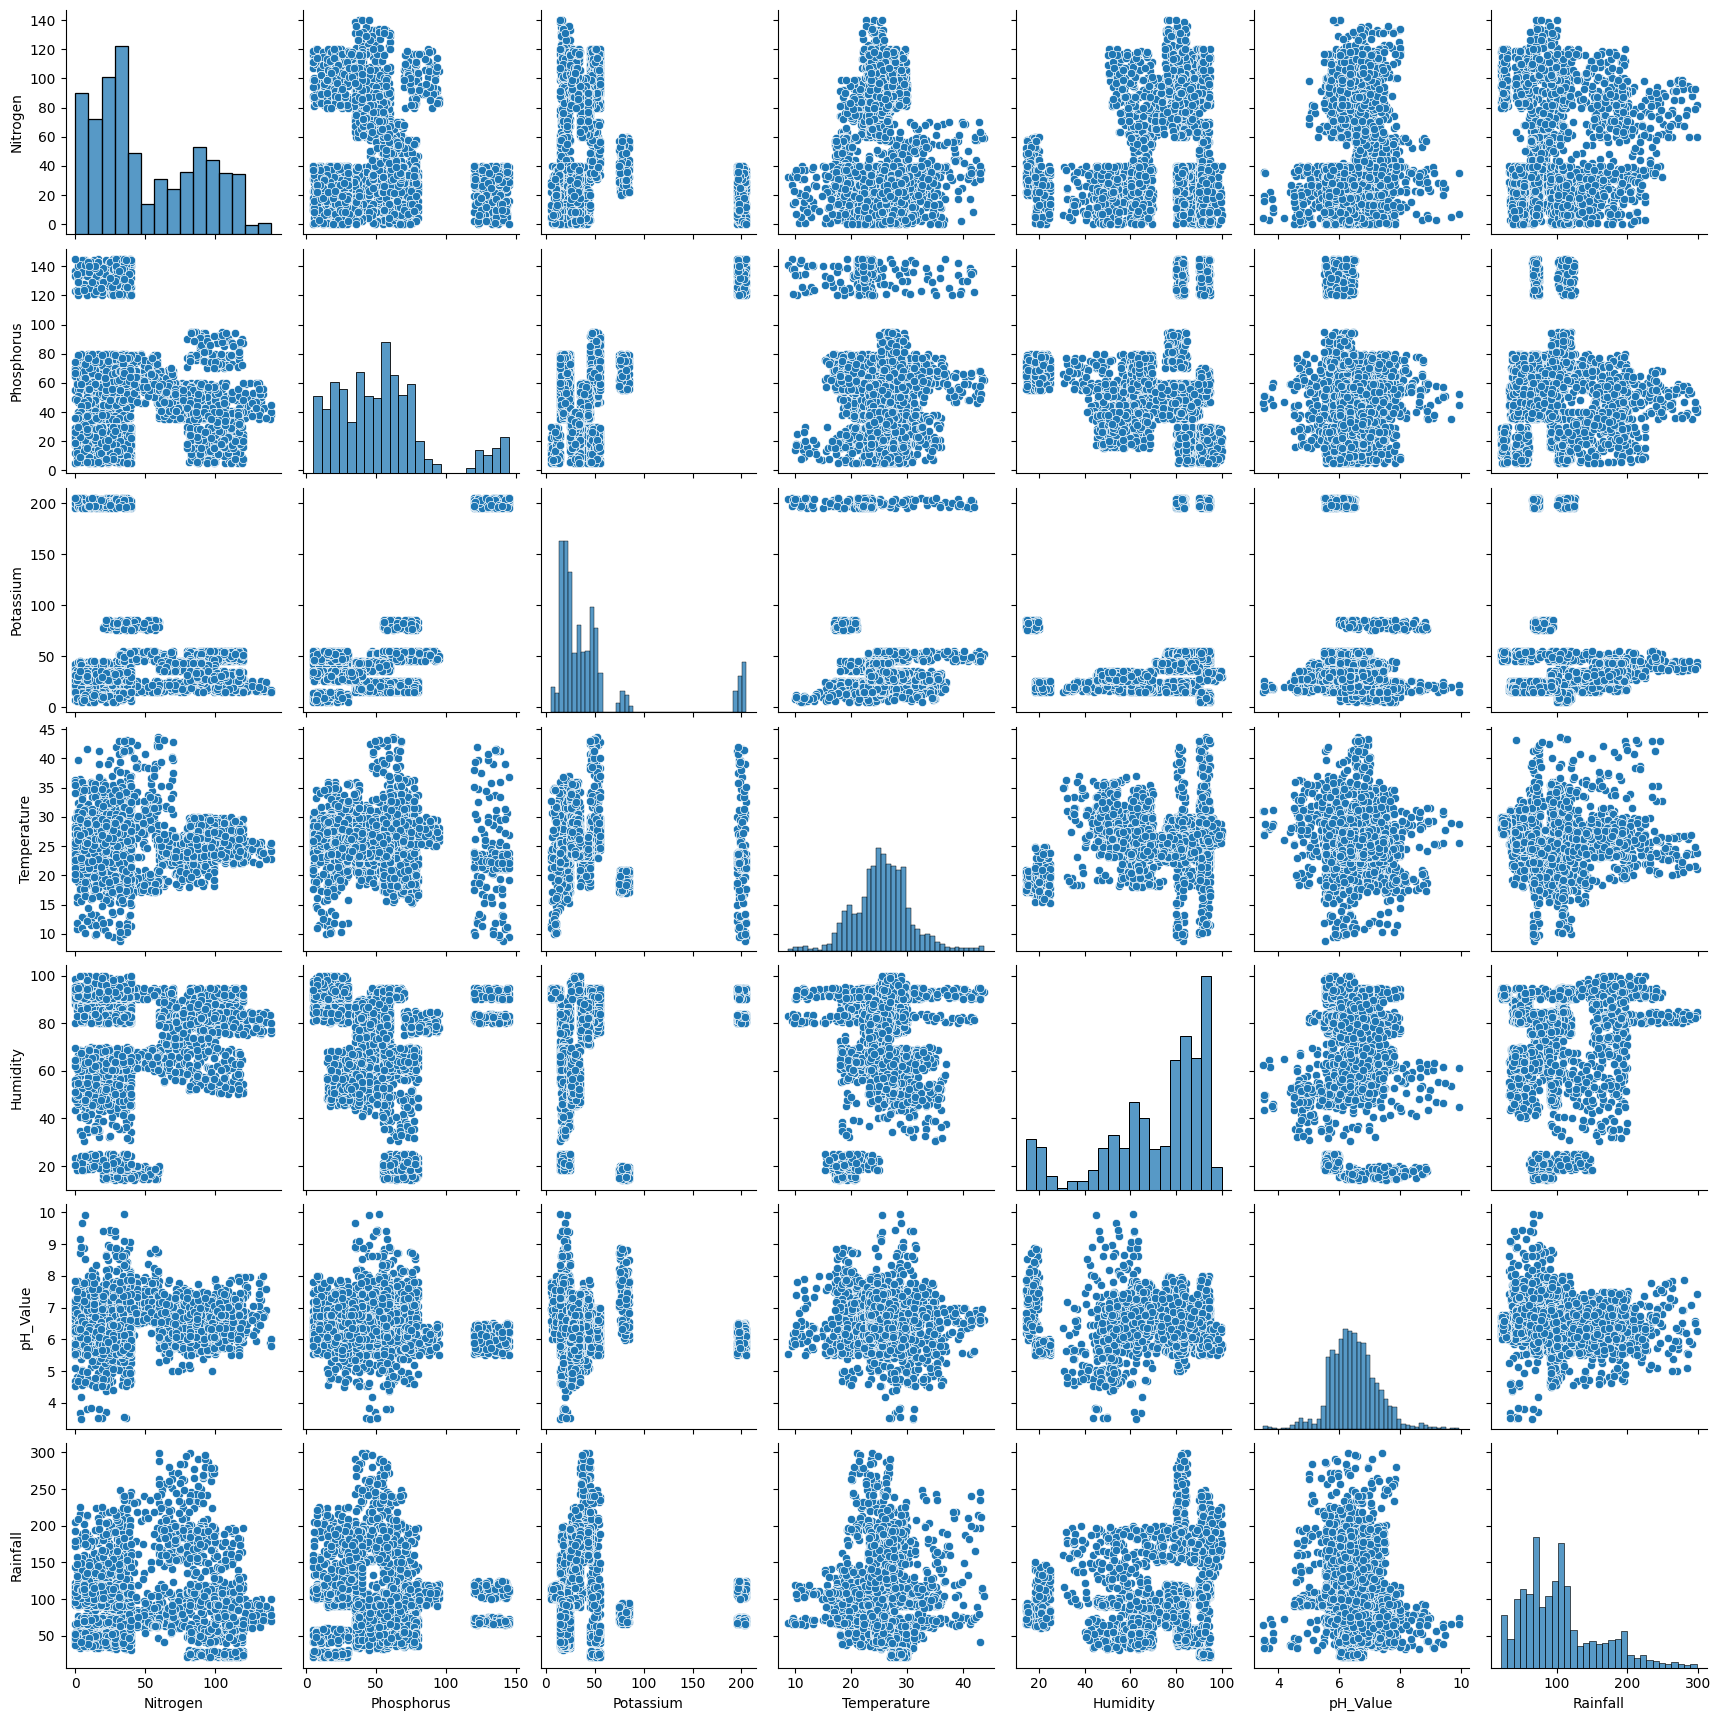

In [3]:
sns.pairplot(dataPD, kind='scatter', diag_kind='hist')

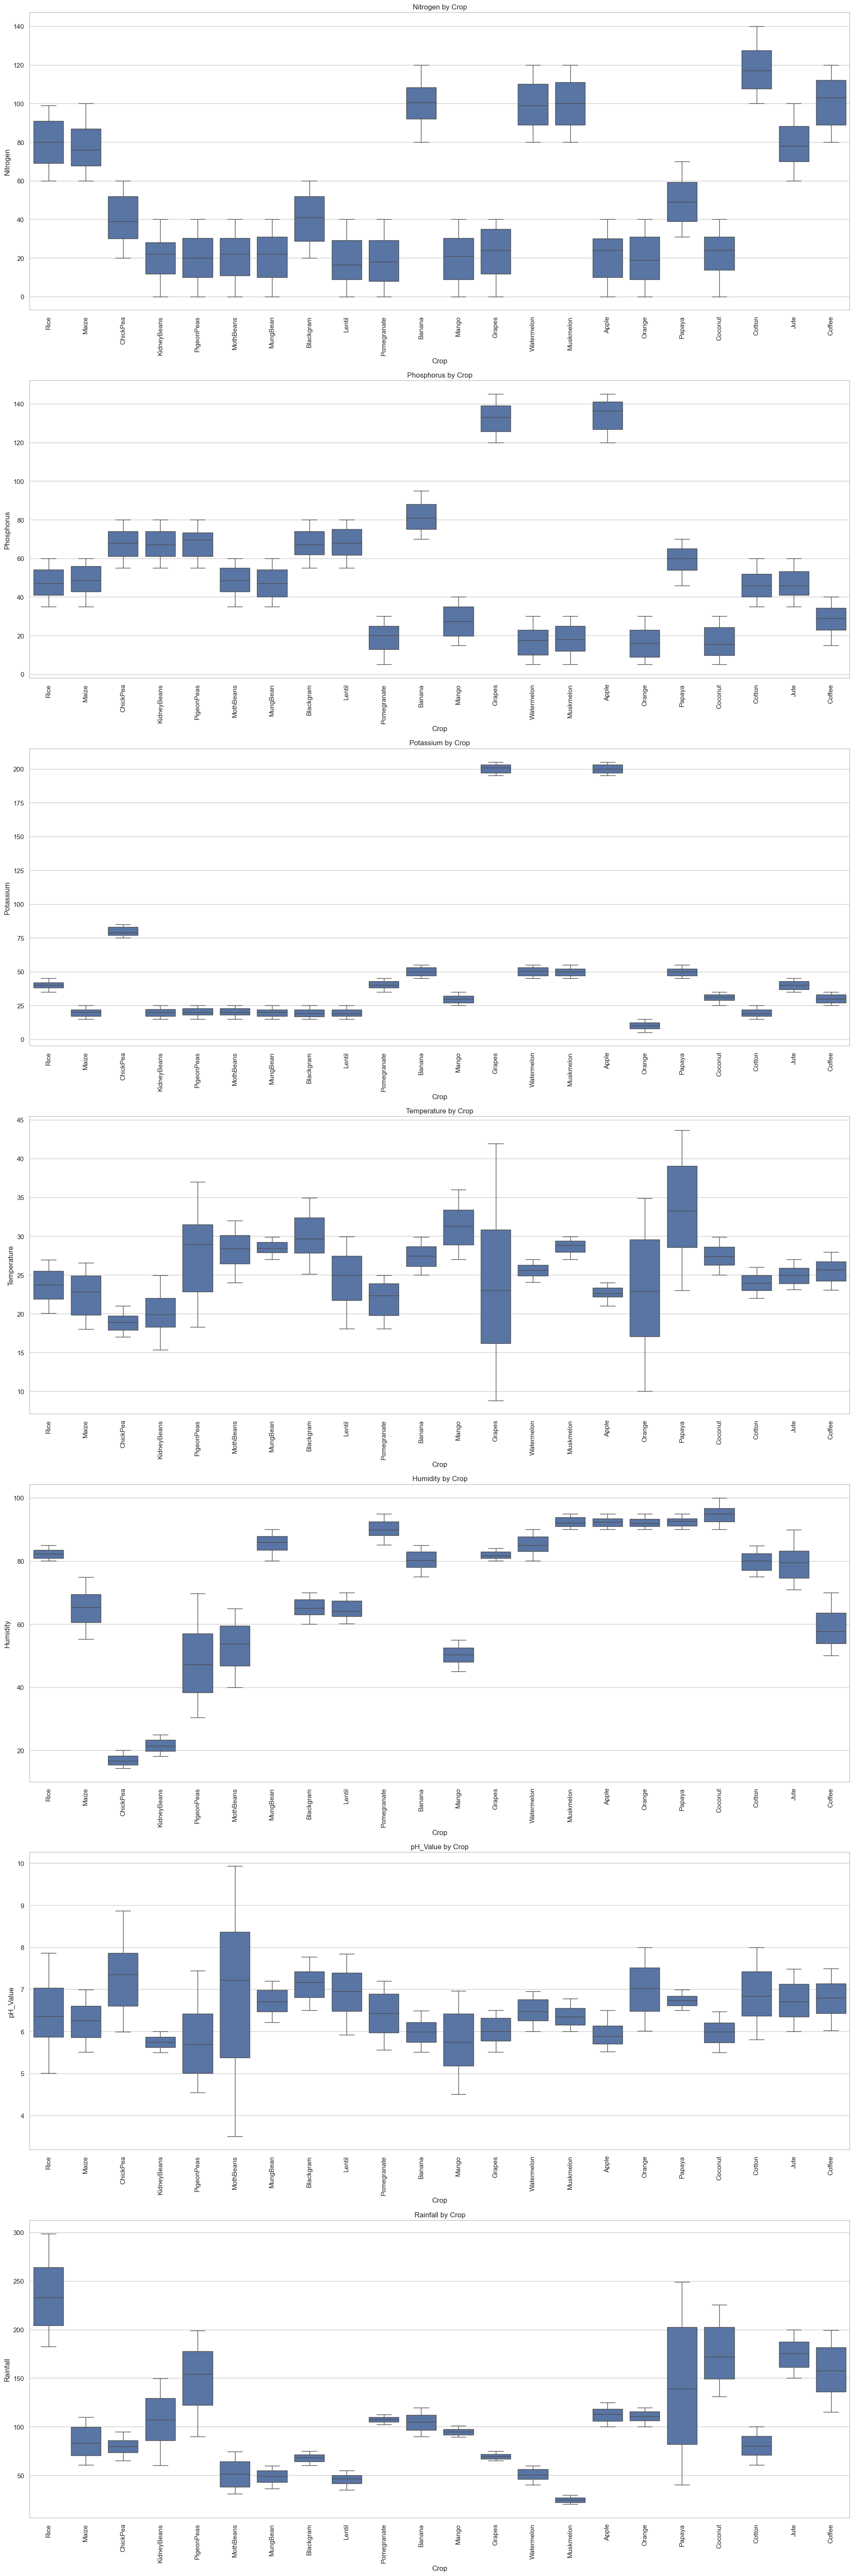

In [4]:
pltColumns = [
    "Nitrogen",
    "Phosphorus",
    "Potassium",
    "Temperature",
    "Humidity",
    "pH_Value",
    "Rainfall",
]

sns.set_theme(style="whitegrid")

# Построение ящиков с усами для каждого числового признака
plt.figure(figsize=(20, 60))

for i, feature in enumerate(pltColumns, 1):
    plt.subplot(7, 1, i)
    sns.boxplot(x="Crop", y=feature, data=dataPD)
    plt.xticks(rotation=90)
    plt.title(f"{feature} by Crop")

plt.tight_layout()
plt.show()

In [5]:
# Преобразование столбцов в float и заполнение пропусков
for col_name in data.columns[:-1]:
    data = data.withColumn(col_name, col(col_name).cast("float")) # type: ignore
    avg_value = data.select(mean(col(col_name))).collect()[0][0]
    data = data.na.fill({col_name: avg_value})

# Удаление столбца 'label', если он уже существует
if "label" in data.columns:
    data = data.drop("label")

# Проверка результата
data.printSchema()
data.show(5)

root
 |-- Азот: float (nullable = false)
 |-- Фосфор: float (nullable = false)
 |-- Калий: float (nullable = false)
 |-- Температура: float (nullable = false)
 |-- Влажность: float (nullable = false)
 |-- Значение pH: float (nullable = false)
 |-- Осадки: float (nullable = false)
 |-- Kультура: string (nullable = true)

+----+------+-----+-----------+---------+-----------+---------+--------+
|Азот|Фосфор|Калий|Температура|Влажность|Значение pH|   Осадки|Kультура|
+----+------+-----+-----------+---------+-----------+---------+--------+
|90.0|  42.0| 43.0|  20.879744| 82.00275|  6.5029855|202.93553|    Rice|
|85.0|  58.0| 41.0|  21.770462| 80.31964|  7.0380964|226.65553|    Rice|
|60.0|  55.0| 44.0|   23.00446| 82.32076|   7.840207|263.96423|    Rice|
|74.0|  35.0| 40.0|  26.491096| 80.15836|   6.980401|242.86403|    Rice|
|78.0|  42.0| 42.0|  20.130175| 81.60487|   7.628473|262.71735|    Rice|
+----+------+-----+-----------+---------+-----------+---------+--------+
only showing top 5 ro

Классификация

In [6]:
# Разделение данных на обучающую и тестовую выборки
train_data, test_data = data.randomSplit([0.8, 0.2])

In [7]:
def plot_cv_results(model_name, cvModel):
    global paramGrids, lr, dt, rf, nb
    paramMaps = paramGrids[model_name] # type: ignore
    avgMetrics = cvModel.avgMetrics

    if model_name == "Logistic Regression":
        regParams = [paramMap[lr.regParam] for paramMap in paramMaps] # type: ignore
        elasticNetParams =  [paramMap[lr.elasticNetParam] for paramMap in paramMaps] # type: ignore
        param1, param2 = "параметр регуляризации", "параметр elasticNet"
        param1_vals, param2_vals = regParams, elasticNetParams
    elif model_name == "Decision Tree":
        depths = [paramMap[dt.maxDepth] for paramMap in paramMaps] # type: ignore
        bins = [paramMap[dt.maxBins] for paramMap in paramMaps] # type: ignore
        param1, param2 = "макс. глубина", "макс. кол-во ячеек"
        param1_vals, param2_vals = depths, bins
    elif model_name == "Random Forest":
        trees = [paramMap[rf.numTrees] for paramMap in paramMaps] # type: ignore
        depths = [paramMap[rf.maxDepth] for paramMap in paramMaps] # type: ignore
        param1, param2 = "кол-во деревьев", "макс. глубина"
        param1_vals, param2_vals = trees, depths
    elif model_name == "Naive Bayes":
        smoothing = [paramMap[nb.smoothing] for paramMap in paramMaps] # type: ignore
        param1, param2 = "сглаживание", None
        param1_vals, param2_vals = smoothing, None

    fig, ax = plt.subplots()
    if param2 is not None:
        scatter = ax.scatter(param1_vals, param2_vals, c=avgMetrics, cmap="viridis")
        ax.set_xlabel(param1)
        ax.set_ylabel(param2)
    else:
        scatter = ax.scatter(
            param1_vals, [0] * len(param1_vals), c=avgMetrics, cmap="viridis"
        )
        ax.set_xlabel(param1)

    ax.set_title(f"Результаты перекрестного валидирования для {model_name}")
    colorbar = fig.colorbar(scatter)
    colorbar.set_label("Точность")
    plt.show()

In [8]:
def plot_confmatrix_results(predictions):
    # Выбираем столбцы "prediction" и "label"
    preds_and_labels = predictions.select("prediction", "label")

    # Вычисляем матрицу ошибок
    conf_matrix = preds_and_labels.groupBy("label", "prediction").count().toPandas()

    # Переводим в сводную таблицу
    conf_matrix_pivot = (
        conf_matrix.pivot(index="label", columns="prediction", values="count")
        .fillna(0)
        .astype(int)
    )

    # Отрисовываем матрицу ошибок
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_pivot, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Предсказанные значения")
    plt.ylabel("Реальные значения")
    plt.title("Матрица ошибок")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

In [9]:
# Инициализируем модели
lr = LogisticRegression(featuresCol="scaledFeatures")
dt = DecisionTreeClassifier(featuresCol="scaledFeatures")
rf = RandomForestClassifier(featuresCol="scaledFeatures")
nb = NaiveBayes(featuresCol="scaledFeatures")

# Создание сеток гиперпараметров
paramGrids = {
    "Logistic Regression": ParamGridBuilder()
    .addGrid(lr.regParam, [0.01, 0.1, 1.0])
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
    .build(),
    "Decision Tree": ParamGridBuilder()
    .addGrid(dt.maxDepth, [5, 10, 15, 20])
    .addGrid(dt.maxBins, [32, 48, 64])
    .build(),
    "Random Forest": ParamGridBuilder()
    .addGrid(rf.numTrees, [10, 20, 40])
    .addGrid(rf.maxDepth, [5, 10, 20])
    .build(),
    "Naive Bayes": ParamGridBuilder()
    .addGrid(nb.smoothing, [0.5, 1.0, 1.5])
    .build()
}
# Векторизация данных
assembler = VectorAssembler(inputCols=data.columns[:-1], outputCol="features")

# Нормализация данных с использованием MinMaxScaler
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures", min=1, max=10)

# Преобразование категориального столбца в числовой
indexer = StringIndexer(inputCol="Kультура", outputCol="label")

# Создание оценщика
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy"
)
# Кросс-валидация и оценка всех моделей
results = {}

In [10]:
# Функция для pipeline и выполнения кросс-валидации
def perform_cross_validation(model_name, model, paramGrid):
    pipeline = Pipeline(stages=[indexer, assembler, scaler, model])
    cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
    cvModel = cv.fit(train_data)
    predictions = cvModel.transform(test_data)
    accuracy = evaluator.evaluate(predictions)
    results[model_name] = (accuracy, cvModel)
    print(f"Точность {model_name}: {accuracy:.4f}")
    # Визуализация результатов кросс-валидации
    plot_cv_results(model_name, cvModel)
    plot_confmatrix_results(predictions)

Точность Logistic Regression: 0.9279


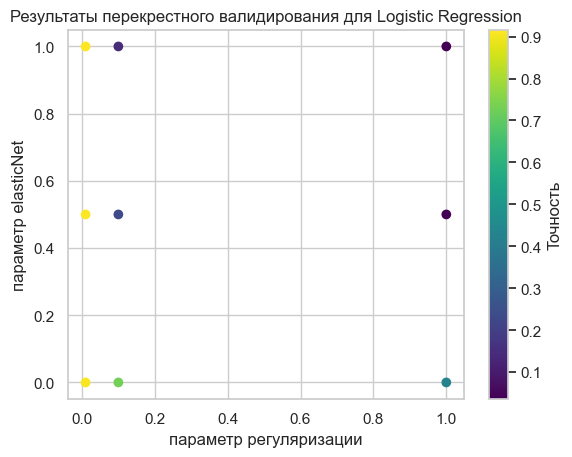

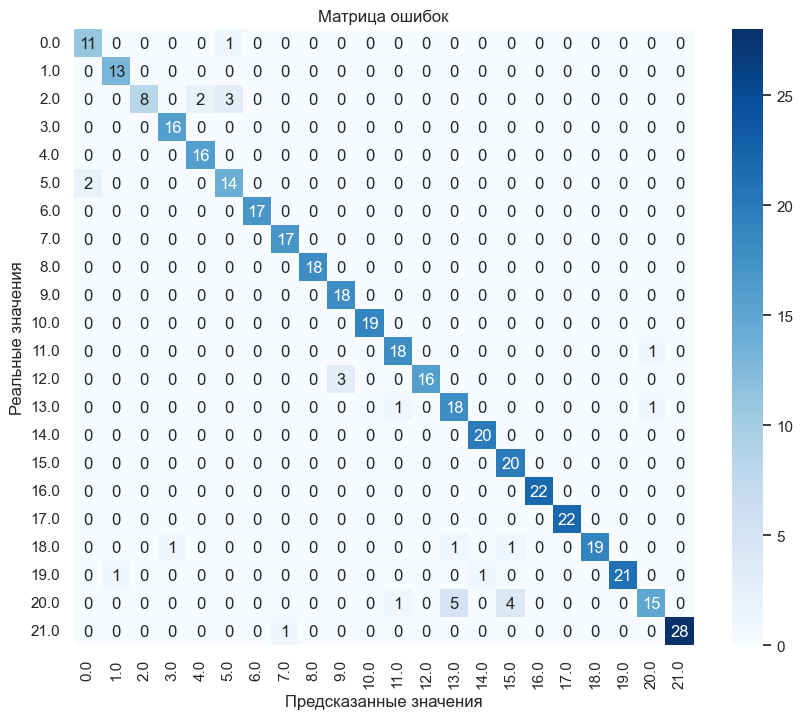

Точность Decision Tree: 0.9760


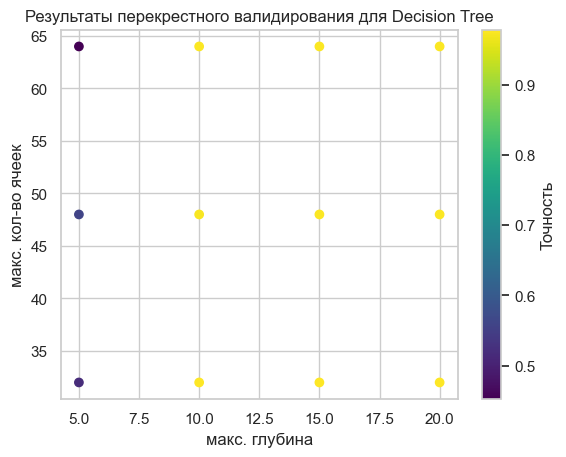

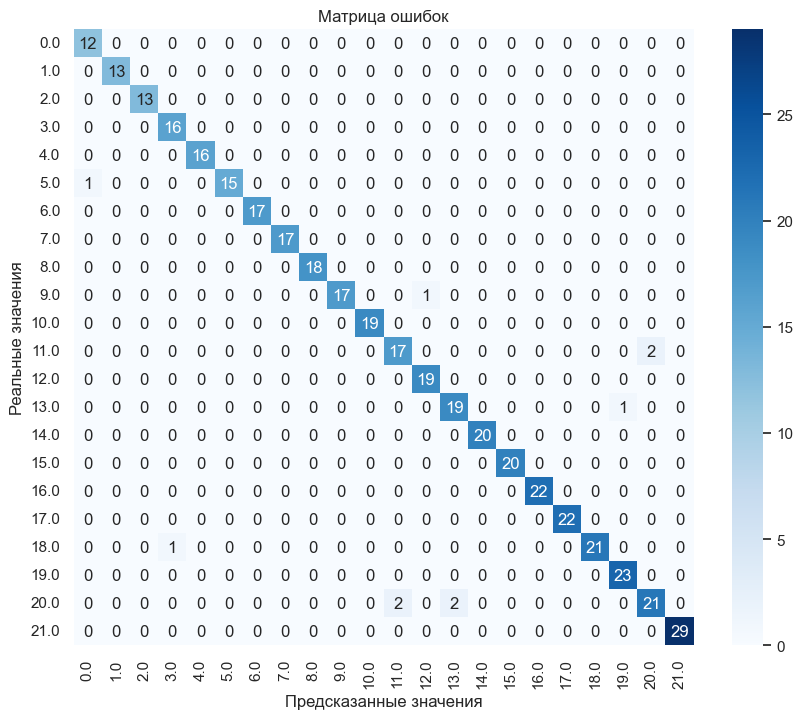

Точность Random Forest: 0.9808


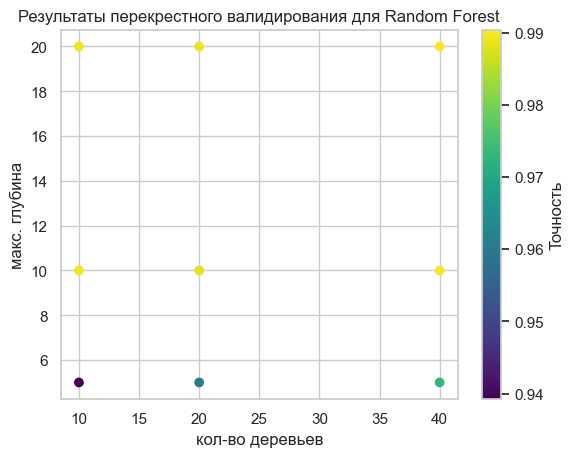

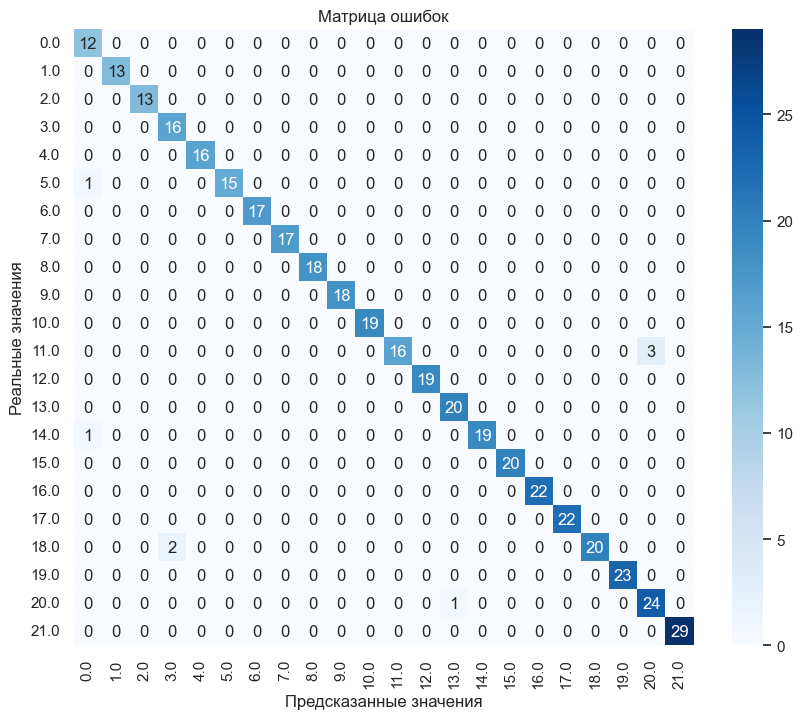

Точность Naive Bayes: 0.8942


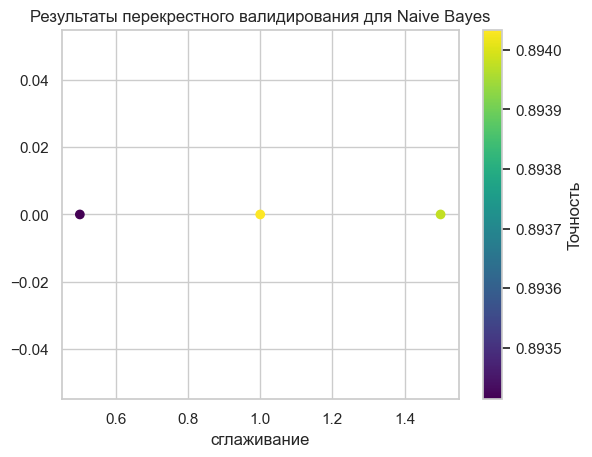

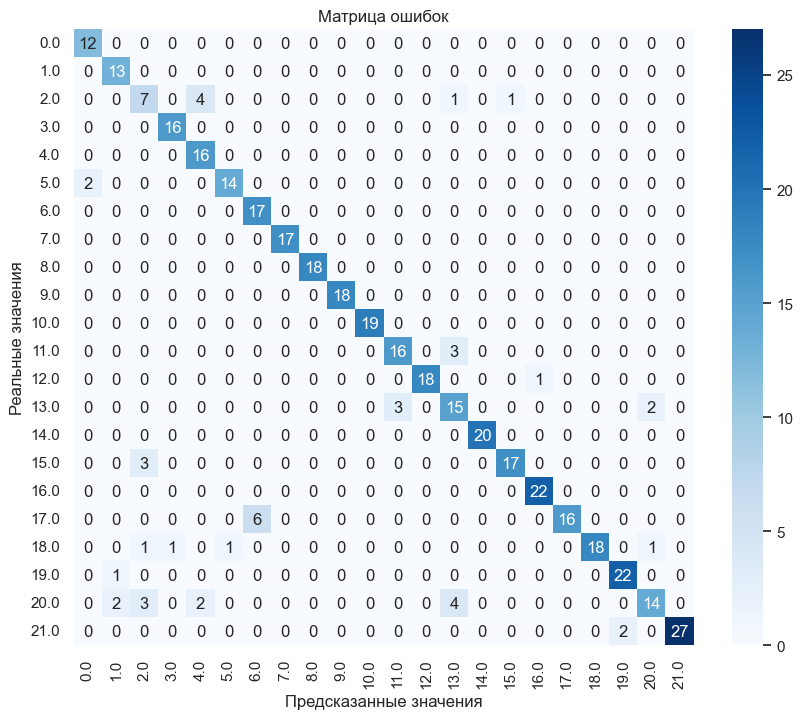


Лучшая модель: Random Forest с точностью: 0.9808
Лучшие параметры: кол-во деревьев=40, макс. глубина=20


In [11]:
# Выполняем кросс-валидацию для каждой модели
perform_cross_validation('Logistic Regression', lr, paramGrids['Logistic Regression'])
perform_cross_validation('Decision Tree', dt, paramGrids['Decision Tree'])
perform_cross_validation('Random Forest', rf, paramGrids['Random Forest'])
perform_cross_validation('Naive Bayes', nb, paramGrids['Naive Bayes'])

# Поиск лучшей модели
best_model_name, (best_accuracy, best_cvModel) = max(results.items(), key=lambda item: item[1][0])

print(f"\nЛучшая модель: {best_model_name} с точностью: {best_accuracy:.4f}")

# Вывод лучших гиперпараметров для лучшей модели
best_pipeline_model = best_cvModel.bestModel    # Доступ к лучшей PipelineModel из CrossValidatorModel
bestModel = best_pipeline_model.stages[-1]      # Последний этап pipeline
bestParams = bestModel.extractParamMap()        # Вывод лучших гиперпараметров

paramStr = ""
if best_model_name == "Logistic Regression":
    paramStr = f"Лучшие параметры: параметр регуляризации={bestParams[lr.regParam]}, параметр elasticNet={bestParams[lr.elasticNetParam]}"
elif best_model_name == "Decision Tree":
    paramStr = f"Лучшие параметры: макс. глубина={bestParams[dt.maxDepth]}, макс. кол-во ячеек={bestParams[dt.maxBins]}"
elif best_model_name == "Random Forest":
    paramStr = f"Лучшие параметры: кол-во деревьев={bestParams[rf.numTrees]}, макс. глубина={bestParams[rf.maxDepth]}"
elif best_model_name == "Naive Bayes":
    paramStr = f"Лучшие параметры: сглаживание={bestParams[nb.smoothing]}"

print(paramStr)

Кластеризация (WCSS)

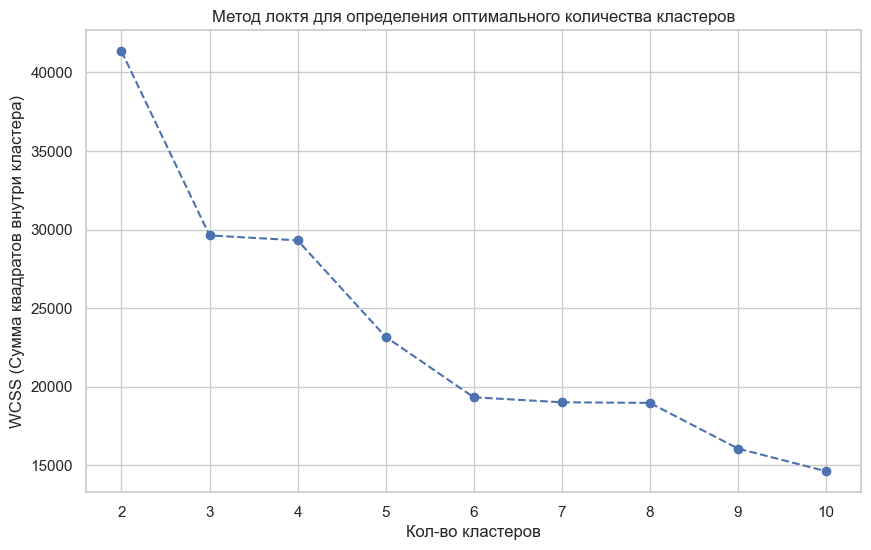

In [12]:
if "prediction" in data.columns:
    data = data.drop("prediction")

# Определение количества кластеров с использованием метода локтя
wcss = []
for K in range(2, 11):
    kmeans = BisectingKMeans(featuresCol="scaledFeatures", k=K)
    pipeline = Pipeline(stages=[indexer, assembler, scaler, kmeans])
    model = pipeline.fit(data)
    wcss.append(model.stages[-1].summary.trainingCost) # type: ignore

# Визуализация метода локтя
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), wcss, marker="o", linestyle="--")
plt.title("Метод локтя для определения оптимального количества кластеров")
plt.xlabel("Кол-во кластеров")
plt.ylabel("WCSS (Сумма квадратов внутри кластера)")
plt.show()

Кластеризация

In [13]:
if "pcaFeatures" in data.columns:
    data = data.drop("pcaFeatures")

if "Кластер" in data.columns:
    data = data.drop("Кластер")

if "label" in data.columns:
    data = data.drop("label")

# Оптимальное количество кластеров (предположим 4)
n_clusters = 4
kmeans = KMeans(k=n_clusters, featuresCol="scaledFeatures")
pipeline = Pipeline(stages=[indexer, assembler, scaler, kmeans])
model = pipeline.fit(data)
dataCluster = model.transform(data)

# Добавление меток кластеров к датасету
dataCluster = dataCluster.withColumnRenamed("prediction", "Кластер")

# Применение PCA для снижения размерности
pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pcaFeatures")
pca_model = pca.fit(dataCluster)
dataCluster = pca_model.transform(dataCluster)

# Переводим pcaFeatures вектор в массив
dataCluster = dataCluster.withColumn("pcaFeaturesArray", vector_to_array("pcaFeatures")) # type: ignore

# Добавляем признаки PCA как отдельные столбцы
dataCluster = dataCluster.withColumn("PCA1", col("pcaFeaturesArray")[0])
dataCluster = dataCluster.withColumn("PCA2", col("pcaFeaturesArray")[1])

Визуализация кластеризации

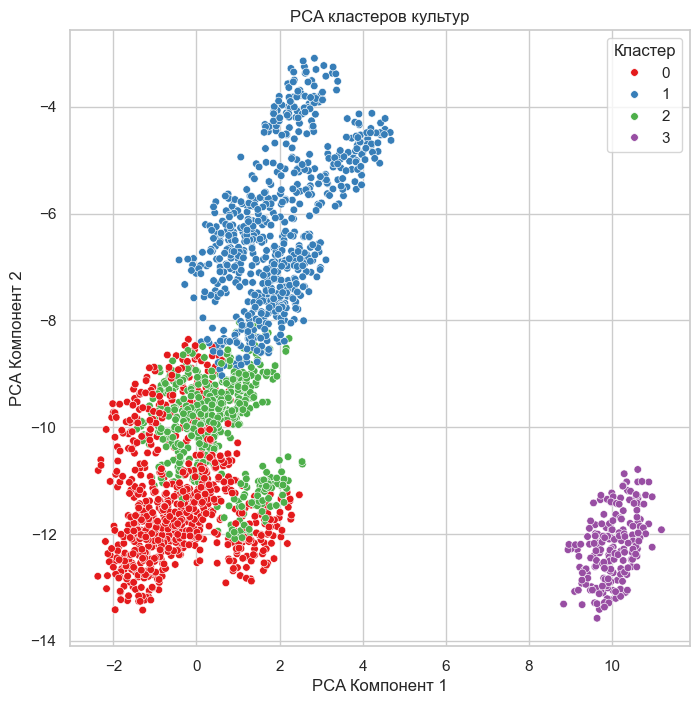

+-------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------+-------------------+-------------------+
|Кластер|         avg(Азот)|       avg(Фосфор)|        avg(Калий)|  avg(Температура)|   avg(Влажность)|  avg(Значение pH)|       avg(Осадки)|        avg(label)|avg(Кластер)|          avg(PCA1)|          avg(PCA2)|
+-------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------+-------------------+-------------------+
|      1|26.627285513361464|   59.042194092827|29.713080168776372| 25.72982541150014|45.87506190566909| 6.504544762787101|  84.6858384498564| 9.583684950773558|         1.0| 1.9523772607202121| -6.277002431886509|
|      3|             21.99|           133.375|             200.0|23.240258736610414| 87.1043053817749| 5.977799801826477|  91.1333039855957|   

In [14]:
# Преобразование данных для визуализации
visualizeClusterInfoPD = dataCluster.select("PCA1", "PCA2", "Кластер").toPandas()

# Визуализация кластеров с использованием PCA
plt.figure(figsize=(8, 8))
sns.scatterplot(
    data=visualizeClusterInfoPD, x="PCA1", y="PCA2", hue="Кластер", palette="Set1", s=30
)
plt.title("PCA кластеров культур")
plt.xlabel("PCA Компонент 1")
plt.ylabel("PCA Компонент 2")
plt.legend(title="Кластер")
plt.show()

# Суммаризация признаков для каждого кластера
cluster_summary = dataCluster.groupBy("Кластер").mean()
cluster_summary.show()

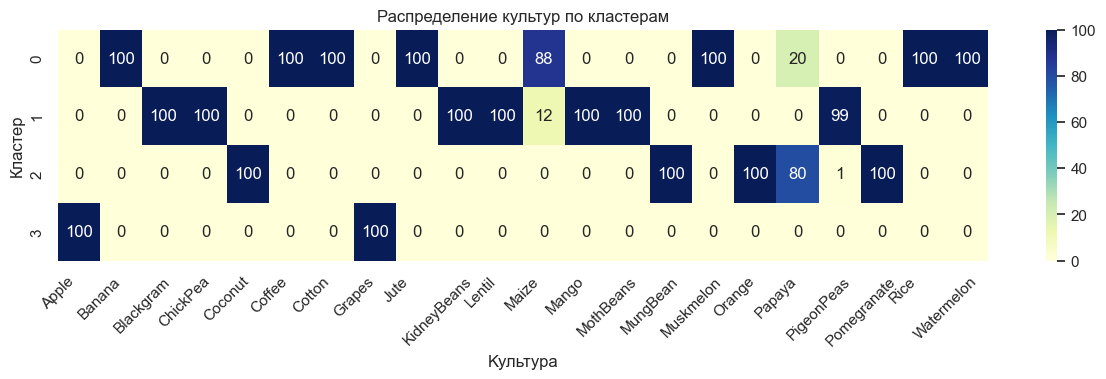

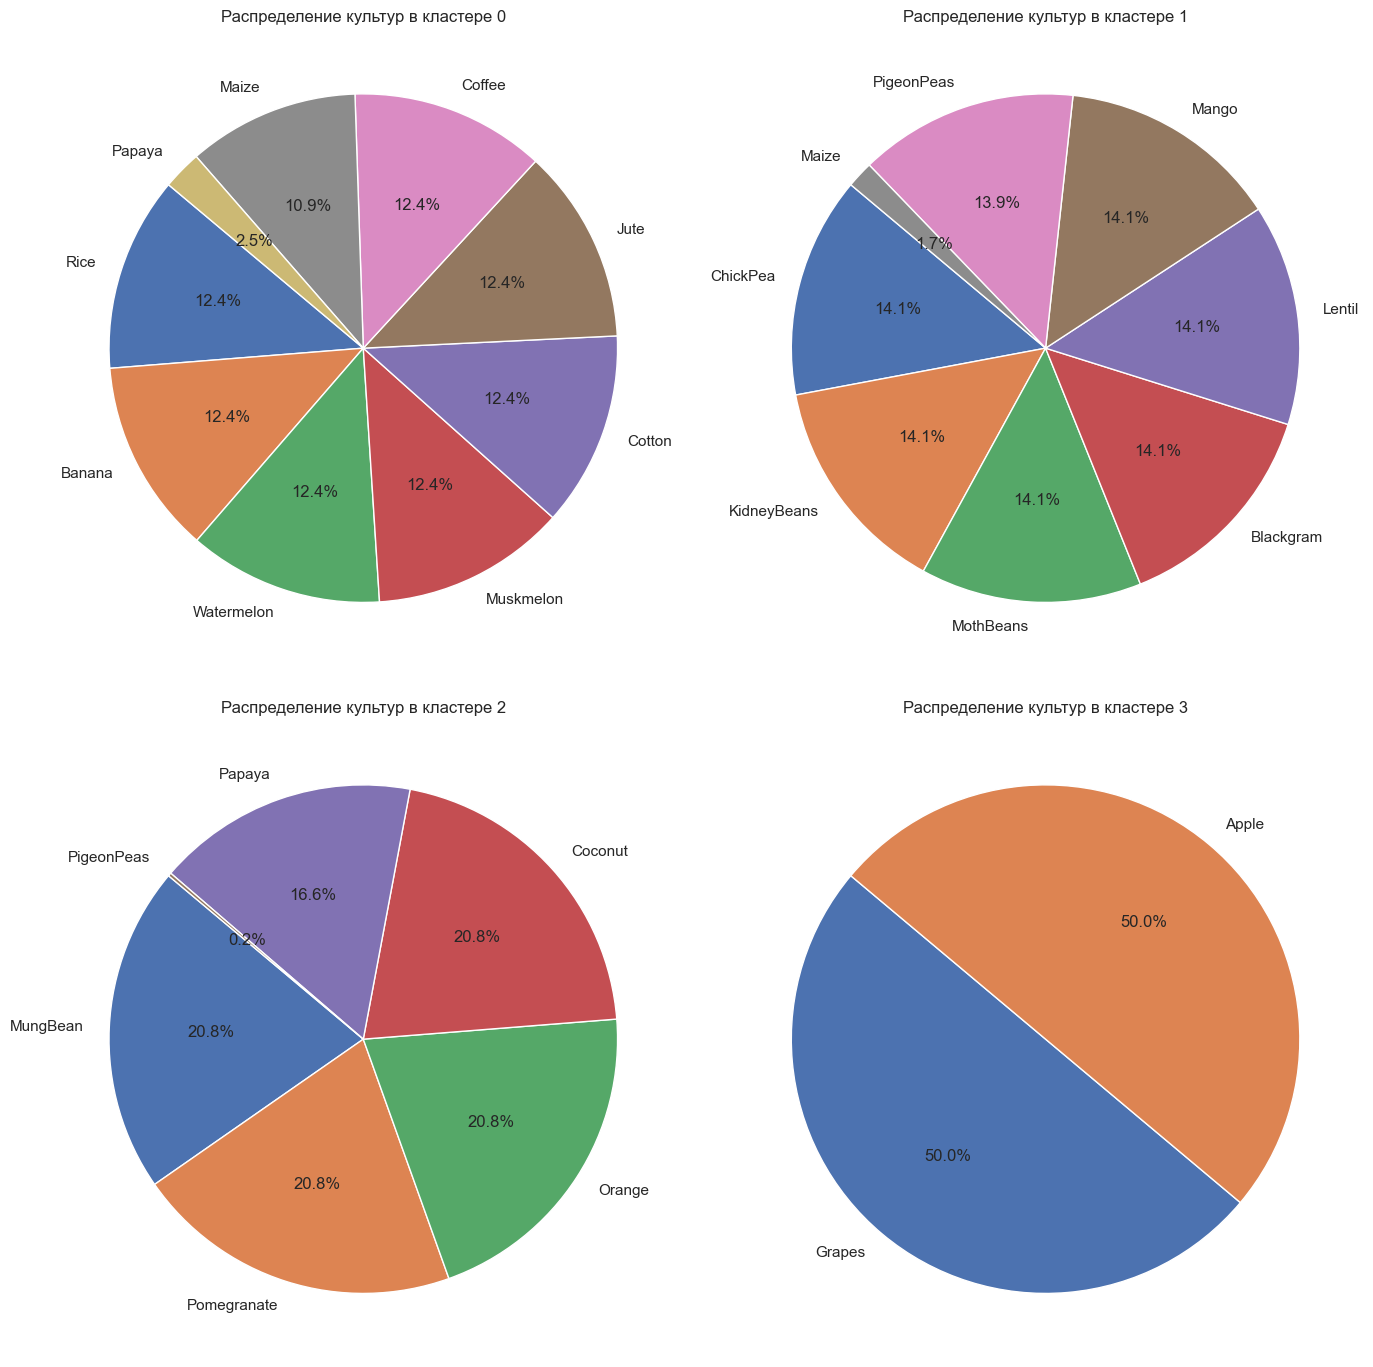

In [15]:
# Извлечение данных для визуализации
visualizeCropbyClusterInfoPD = (
    dataCluster.select("Кластер", "Kультура").orderBy("Кластер").toPandas()
)

# Подсчет количества каждого типа культуры в каждом кластере
crop_cluster_distribution = (
    visualizeCropbyClusterInfoPD.groupby(["Кластер", "Kультура"])
    .size()
    .unstack()
    .fillna(0)
)

# Визуализация распределения культур внутри каждого кластера
plt.figure(figsize=(15, 3))
sns.heatmap(crop_cluster_distribution, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Распределение культур по кластерам")
plt.xlabel("Kультура")
plt.ylabel("Кластер")
plt.xticks(
    ticks=range(len(crop_cluster_distribution.columns)),
    labels=crop_cluster_distribution.columns, # type: ignore
    rotation=45,
)
plt.show()

# Создаем subplots
fig, axs = plt.subplots(
    nrows=(len(visualizeCropbyClusterInfoPD["Кластер"].unique()) + 1) // 2,
    ncols=2,
    figsize=(14, 14),
)
axs = axs.flatten()

# Выводим график
clusters = visualizeCropbyClusterInfoPD["Кластер"].unique()
for cluster in clusters:
    cluster_data = visualizeCropbyClusterInfoPD[
        visualizeCropbyClusterInfoPD["Кластер"] == cluster
    ]
    crop_counts = cluster_data["Kультура"].value_counts()
    axs[cluster].pie(
        crop_counts, labels=crop_counts.index, autopct="%1.1f%%", startangle=140
    )
    axs[cluster].set_title(f"Распределение культур в кластере {cluster}")

plt.tight_layout()
plt.show()